In [1]:
import torchvision
import os, sys
import argparse
import numpy as np
from collections import defaultdict
import json
import time
import multiprocessing
import copy
import os
import os.path as osp
# from utils import IdGenerator, id2rgb
import pdb
import torch
import numpy as np
try:
    import PIL.Image     as Image
except:
    print("Failed to import the image processing packages.")
    sys.exit(-1)
from pycocotools.coco import COCO
import numpy as np
# import skimage.io as io

import random
import numpy as np
import itertools as it
import torch
import torchvision
import json
import bisect
import copy

nBase = 270
nAccum = 20
nGpu = 8 
nStep = nAccum*nGpu
nIter = 100
Step = 1


In [2]:

val_data_path = './dataset/images/val2017'
train_data_path = './dataset/images/train2017'
save_path ='/mnt/data-disk2/xinting/project/dataset/LVIS/lvis_trainval_1230/lvis_step1_2'
# os.makedirs(save_path)
sorted_cls_id_train_file = os.path.join('/mnt/data-disk2/xinting/project/dataset/LVIS/lvis_trainval_1230', 'lvis_sorted_id_all.json')
with open(sorted_cls_id_train_file, 'r') as f:
    sorted_cls_id_train = json.load(f)
# id_step1 = sorted_cls_id_train[:(nBase+nStep*1)]+sorted_cls_id_train[260:300]+sorted_cls_id_train[520:560]+sorted_cls_id_train[760:800]
# id_step1 = sorted_cls_id_train[:(nBase+nStep*Step)]
id_step1 = sorted_cls_id_train[:(nBase+nStep*Step)]

json.dump(id_step1, open(os.path.join(save_path, 'lvis_sorted_id_step1.json'), 'w'))

train_json_file = "/mnt/data-disk2/xinting/project/dataset/LVIS/lvis_v0.5_train.json"
with open(train_json_file, 'r') as f:
    train_gt = json.load(f)

val_json_file = "/mnt/data-disk2/xinting/project/dataset/LVIS/lvis_v0.5_val.json"
with open(val_json_file, 'r') as f:
    val_gt = json.load(f)


In [3]:
def _quantize(x, bins):
    bins = copy.copy(bins)
    bins = sorted(bins)
    quantized = list(map(lambda y: bisect.bisect_right(bins, y), x))
    return quantized


min_keypoints_per_image = 10


def _count_visible_keypoints(anno):
    return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)


def _has_only_empty_bbox(anno):
    return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)


def has_valid_annotation(anno):
    # if it's empty, there is no annotation
    if len(anno) == 0:
        return False
    # if all boxes have close to zero area, there is no annotation
    if _has_only_empty_bbox(anno):
        return False
    # keypoints task have a slight different critera for considering
    # if an annotation is valid
    if "keypoints" not in anno[0]:
        return True
    # for keypoint detection tasks, only consider valid images those
    # containing at least min_keypoints_per_image
    if _count_visible_keypoints(anno) >= min_keypoints_per_image:
        return True
    return False

class COCODataset(torchvision.datasets.coco.CocoDetection):
    def __init__(self, root, ann_file, sorted_id=id_step1, remove_images_without_annotations=False):
        super(COCODataset, self).__init__(root, ann_file)
        self.ids = sorted(self.ids)

        # filter images without detection annotations
        if remove_images_without_annotations:
            ids = []
            for img_id in self.ids:
                ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds = sorted_id,iscrowd=None)
#                 ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)

                anno = self.coco.loadAnns(ann_ids)
                if has_valid_annotation(anno):
                    ids.append(img_id)
            self.ids = ids

        self.categories = {cat['id']: cat['name'] for cat in self.coco.cats.values()}

        self.category_id_to_sorted_id = {
            v: i + 1 for i, v in enumerate(sorted_id)
        }
        self.sorted_id_to_category_id = {
            v: k for k, v in self.category_id_to_sorted_id.items()
        }
        self.id_to_img_map = {k: v for k, v in enumerate(self.ids)}
        self.img_map_to_id = {v: k for k, v in self.id_to_img_map.items()}

#         self._transforms = transforms
        
    def __getitem__(self, idx):
        img, anno = super(COCODataset, self).__getitem__(idx)
#         print(anno)
        return img, anno, idx
    
    def get_img_info(self, index):
        img_id = self.id_to_img_map[index]
        img_data = self.coco.imgs[img_id]
        return img_data



def generate_bin_list(num_all_iters, bin_num, bin_iter_list, if_mix, mix_len=None):
    #Args:
    #     num_all_iters: how many iterstions for the training
    #     bin_num: how many bins the whole tail are seperated 
    #     bin_iter_list: how many iterations for each tail bin
    #     if_mix: whether we look back when training a new tail bin
    #     mix_len: id mix=True, evry new bin we select max_len iterations from previous bins 
    #Return:
    #     a list of bin_id for training iterations
    assert len(bin_iter_list) == bin_num   
    assert sum(bin_iter_list) == num_all_iters
    
    bin_list = [0]* num_all_iters
    start_iter = 0
    for bin_id, bin_len in enumerate(bin_iter_list):
        cur_list = [bin_id]*bin_len
        if if_mix and (bin_id!=0):
            mix_list = []  #the list of previous bins
            for pre_bin in range(0, bin_id):
                iters_pre = int(np.floor(mix_len/bin_id))  #在所有的previous bins中平分这些replay iterations
                mix_list.extend([pre_bin]*iters_pre)
#             import pdb;pdb.set_trace()
            random.shuffle(mix_list)
            mix_iters = random.sample(range(0, bin_len), iters_pre*bin_id)
            cur_list_np = np.array(cur_list)
            cur_list_np[mix_iters] = mix_list 
            cur_list = list(cur_list_np)
#             for mix_iter in mix_iters:
#                 cur_list[mix_iter] = mix_list
        bin_list[start_iter: start_iter+bin_len] = cur_list
        start_iter += bin_len
    return bin_list
# a = generate_bin_list(20, 4,[5,5,5,5],True,4)

def get_iteration_info(coco, data_info, bin_list, aspect_group=True):
    # Args:
    #   data_info: the data information: how the bins are construacted, img_ids and category_id for each class
    #   ntail_cls_list: the classes each tail bin has (现在初步认为所有的bin都一样长)
    #       len(ntail_cls_list): how many tails
    #       len(ntail_cls_list[0]): how many classes in bin0
    #   bin_list: the steps for continue learning bins
    # 对bin_list进行统计
    num_bins = len(data_info)
    iteration_per_bin = []
    for bin_id in range(num_bins):
#         import pdb; pdb.set_trace()
        iteration_per_bin.extend([int(sum(np.array(bin_list)==bin_id)*1)]) #get the tatol iteration numbers foer each bin
        for cls_rank in range(len(data_info[0])):
            cls_id_c = data_info[bin_id][cls_rank]['cls_id'] 
            img_ids_c = data_info[bin_id][cls_rank]['img_ids'] 
            total_iteration = iteration_per_bin[bin_id]
            epochs = int(np.floor(total_iteration/len(img_ids_c)))
            iter_img_id = []
            for epoch in range(epochs):
                g = torch.Generator()
                g.manual_seed(epoch)
                index_i = torch.randperm(len(img_ids_c), generator=g).tolist()
                img_id_i = [img_ids_c[index] for index in index_i]
                iter_img_id.extend(img_id_i)
            iter_img_id += img_ids_c[: (total_iteration - len(iter_img_id))]
            #对img_id做aspect_grouping处理:
            if aspect_group:
                aspect_ratios = []
                iter_img_id_aspect = []
                aspect = [[],[]]
                for iter_img_id_i in iter_img_id:
                    img_info = coco.get_img_info(iter_img_id_i)
                    aspect_ratio = float(img_info["height"]) / float(img_info["width"])
                    aspect_ratios.append(aspect_ratio)
#                 import pdb; pdb.set_trace()
                group_ids = _quantize(aspect_ratios, [1])
        
                aspect[0] = torch.tensor(iter_img_id)[torch.tensor(group_ids)==0].tolist()
                aspect[1] = torch.tensor(iter_img_id)[torch.tensor(group_ids)==1].tolist()

#                 for iter_img_id_i in iter_img_id:
#                     if aspect_dict[iter_img_id_i] ==0:
#                         aspect[0].extend([iter_img_id_i])
#                     else:
#                         aspect[1].extend([iter_img_id_i])
                
                #补充成偶数
                if len(aspect[0])%2!=0:
                    aspect[0].extend([aspect[0][0]])
                len_0 = int(np.ceil(len(aspect[0])/2))
                if len(aspect[1])%2!=0:
                    aspect[1].extend([aspect[1][0]])
                len_1 = int(np.ceil(len(aspect[1])/2))
                    
                aspect_list = [1]*len_1+[0]*len_0
                random.shuffle(aspect_list)
                point=[0,0]
                for aspect_i in aspect_list:
                    iter_img_id_aspect.extend(aspect[aspect_i][point[aspect_i]:point[aspect_i]+2])
                    point[aspect_i]+=2
#                 import pdb; pdb.set_trace()

                iter_img_id = iter_img_id_aspect

            data_info[bin_id][cls_rank]['iter_img_id'] = iter_img_id
            
def get_iteration_batchs(data_info, bin_list):
    #考虑到gpu是distributed -> indices是一个num_gpus*total_iteration的list
    indices = []
    cls_list = []
    bin_num = len(data_info)
    classes_per_bin = len(data_info[0])
    for cls_rank in range(classes_per_bin):
        indices_c = []
        cls_list_c = []
        point = [0]*bin_num
        for bin_id in bin_list:
            indices_c.extend([data_info[bin_id][cls_rank]['iter_img_id'][point[bin_id]]])
            cls_list_c.extend([data_info[bin_id][cls_rank]['cls_id']])
            point[bin_id]+=1
        indices.append(indices_c)
        cls_list.append(cls_list_c)
    return indices, cls_list

def get_img_info(all_tail_classes, img_ids, classes_per_bin):
    # Args:
    #   all_tail_classes； all the tail category id
    #   img_ids: img_ids for each category
    # Return:
    #   data_info: list of bins list of classes' ids
    num_bins = int(len(all_tail_classes)/classes_per_bin)
    data_info = []
    for bin_id in range(num_bins):
        data_info_bin = []
        for cls_rank in range(classes_per_bin):
            data_info_cls = {}
            c = bin_id*classes_per_bin+cls_rank
            data_info_cls['cls_id'] = all_tail_classes[c]
            data_info_cls['img_ids'] = img_ids[c]
            data_info_bin.append(data_info_cls)   
        data_info.append(data_info_bin) 
    return data_info

In [4]:
len(id_step1[-nStep:])

160

## lvis_v0.5_val_stepn：含有base到第n个step的clases的子集

In [33]:
# coco_train_tail = COCODataset(train_data_path, train_json_file, id_step1[-nStep:], True)
coco_train = COCODataset(train_data_path, train_json_file, id_step1, True)

train_gt_step1 = {}
train_annotations_step1= []
train_images_step1 = []
train_images_per_c_step1 = []
for class_i in id_step1:
    img_ids_cls_i_wo_select = coco_train.coco.getImgIds(catIds=class_i)
    img_ids_cls_i = []
    for img_id_cls_i in img_ids_cls_i_wo_select:
        ann_ids = coco_train.coco.getAnnIds(imgIds=img_id_cls_i, catIds = class_i,iscrowd=None)
#                 ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anno = coco_train.coco.loadAnns(ann_ids)
#         print(anno)
        if has_valid_annotation(anno):
            img_ids_cls_i.append(img_id_cls_i)
        else:
            print(img_id_cls_i)
#     if class_i in id_step1[-nStep:]:
#         img_ids_cls_i = list(set(img_ids_cls_i).intersection((set(coco_train_tail.ids))))
    train_images_step1.extend(img_ids_cls_i)
    train_images_per_c_step1.append(img_ids_cls_i)
    annIds_train = coco_train.coco.getAnnIds(imgIds=img_ids_cls_i,catIds=class_i)
    train_annotations_step1.extend(coco_train.coco.loadAnns(ids=annIds_train))
train_images_step1 = list(np.unique(np.array(train_images_step1)))
# annIds_train_step1 = coco_train.coco.getAnnIds(imgIds=train_images_step1,catIds=id_step1)
# train_annotations_step1.extend(coco_train.coco.loadAnns(ids=annIds_train_step1))
    
#     train_annotations_step1.extend(coco_train.coco.loadAnns(ids=annIds_train_step1))
train_gt_step1['annotations'] = train_annotations_step1
train_gt_step1['categories'] = list(item for item in train_gt['categories'] if item['id'] in id_step1)
train_gt_step1['images'] = list(item for item in train_gt['images'] if item['id'] in train_images_step1)



loading annotations into memory...
Done (t=12.11s)
creating index...
index created!
578055
257270
144929
138970
492990
288236
98182
129440
454610
197629


In [34]:
len(train_images_step1)

56205

In [13]:

coco_val = COCODataset(val_data_path, val_json_file, id_step1, True)
val_gt_step1 = {}
val_annotations_step1= []

loading annotations into memory...
Done (t=0.86s)
creating index...
index created!


In [14]:
json.dump(train_gt_step1, open(os.path.join(save_path, 'lvis_v0.5_train_step1.json'), 'w'))


In [15]:
train_gt_step1.keys()

dict_keys(['annotations', 'categories', 'images'])

In [16]:
val_images_step1 = []
for class_i in id_step1:
    img_ids_cls_i = coco_val.coco.getImgIds(catIds=class_i)
#     img_ids_cls_i = list(set(img_ids_cls_i).intersection((set(coco_val.ids))))
    val_images_step1.extend(img_ids_cls_i)
    annIds_val = coco_val.coco.getAnnIds(imgIds=img_ids_cls_i,catIds=class_i)
    
    val_annotations_step1.extend(coco_val.coco.loadAnns(ids=annIds_val))
    
#     val_annotations_step1.extend(coco_val.coco.loadAnns(ids=annIds_val_step1))
val_gt_step1['annotations'] = val_annotations_step1
val_gt_step1['categories'] = list(item for item in val_gt['categories'] if item['id'] in id_step1)
val_gt_step1['images'] = list(item for item in val_gt['images'] if item['id'] in val_images_step1)

In [17]:
for i in val_gt_step1['categories']:
    if i['id'] in id_step1[:nBase]:
        i['step_state'] = 'b0'
    elif i['id'] in id_step1[nBase:nBase+nStep*1]:
        i['step_state'] = 't0'
    else:
        i['step_state'] = 't1'
json.dump(val_gt_step1, open(os.path.join(save_path, 'lvis_v0.5_val_step1.json'), 'w'))



In [18]:
train_step1_json_file = save_path + "/lvis_v0.5_train_step1.json"
train_data_path = './dataset/LVIS/images/train2017'

with open(train_step1_json_file, 'r') as f:
    train_step1 = json.load(f)
coco_step1 = COCODataset(train_data_path, train_step1_json_file, id_step1, True)

loading annotations into memory...
Done (t=20.65s)
creating index...
index created!


In [64]:
coco_step1.coco.getAnnIds(imgIds=581929)

[213564, 213565]

In [68]:
tail_idx_step1 = list(range(nBase+1+nStep*(Step-1),nBase+1+nStep*Step))
tail_images_step1 = []
all_tail_images_step1 = []
for idx_c in tail_idx_step1:    
    tail_images_step1.append([coco_step1.img_map_to_id[idx] for idx in train_images_per_c_step1[idx_c-1]])
    all_tail_images_step1.extend([coco_step1.img_map_to_id[idx] for idx in train_images_per_c_step1[idx_c-1]])

In [70]:
print('images number:',len(all_tail_images_step1))

images number: 16349


In [23]:
# bin_list = list(np.arange(nAccum))*nIter
nIter=800
# bin_list = [0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7]*nIter
bin_list = [0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13,14,14,15,15,16,16,17,17,18,18,19,19]*nIter
# # get_img_info(all_tail_classes, img_ids, classes_per_bin)
data_info_sup  = get_img_info(tail_idx_step1, tail_images_step1, 8)

get_iteration_info(coco_step1, data_info_sup, bin_list, False) 
indices_all, classes_all = get_iteration_batchs(data_info_sup, bin_list)  #indices可以替换dataloader的indices classes存成json告诉网络当前train的是什么class

In [24]:
indices_sup = []
indices_qry = []
classes_sup = []
for indice, classes in zip(indices_all, classes_all):
    classes_sup.append(classes[0::2])
    indices_sup.append(indice[0::2])
    indices_qry.append(indice[1::2])


In [25]:
nIterAll = len(indices_sup[0])*nGpu
print('all iterations:', nIterAll)

all iterations: 128000


In [26]:
json.dump(indices_sup, open(os.path.join(save_path, 'lvis_indices_sup_step1.json'), 'w'))
json.dump(classes_sup, open(os.path.join(save_path, 'lvis_indices_sup_cls_step1.json'), 'w'))
# json.dump(indices_qry, open(os.path.join(save_path, 'lvis_indices_qry_step1.json'), 'w'))


In [27]:
len(indices_sup[0])

16000

In [18]:
for i in indices_sup[0][:15]:
    print()
    for ann in coco_step1[i][1]:
        print(coco_step1.category_id_to_sorted_id[ann['category_id']])


3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
50
50
50
50
50
50
50
50
50
50
50
61
61
61
61
61
61
61
61
61
61
61
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
72
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
209
269
269
269
269
269
269
269
269
269
269
269
271
271
271
271
271
271
284
284
284
284
284
284

95
279
430

100
287

295
295

17
17
77
77
77
77
77
77
77
77
77
77
173
173
303

52
52
52
52
52
52
52
52
52
62
65
66
66
66
66
105
157
157
311
311

211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211
211


## construct random sample indices_qry:

In [28]:

total_iteration = nIterAll
all_tail_images_step1 = []
for tail_image_step1 in tail_images_step1:
    all_tail_images_step1.extend(tail_image_step1)
all_tail_images_step1 = list(np.unique(np.array(all_tail_images_step1)))
epochs = int(np.floor(total_iteration/len(all_tail_images_step1)))
iter_img_id = []
for epoch in range(epochs):
    g = torch.Generator()
    g.manual_seed(epoch)
    index_i = torch.randperm(len(all_tail_images_step1), generator=g).tolist()
    img_id_i = [all_tail_images_step1[index] for index in index_i]
    iter_img_id.extend(img_id_i)
iter_img_id += all_tail_images_step1[: (total_iteration - len(iter_img_id))]


iter_img_id_reshape = np.array(iter_img_id).reshape((nGpu, -1))
iter_img_id_qry = iter_img_id_reshape.tolist()
json.dump(iter_img_id_qry, open(os.path.join(save_path, 'lvis_indices_qry_step1_rand.json'), 'w'))


In [29]:
len(all_tail_images_step1)


12852

In [30]:
np.shape(iter_img_id_reshape)

(8, 16000)

In [31]:
# iter_img_id_qry = iter_img_id_reshape.tolist()
len(iter_img_id_qry[0])

16000

In [32]:
with open(os.path.join(save_path, 'lvis_indices_qry_step1_rand.json'), 'r') as f:
    iter_img_id_qry = json.load(f)

In [35]:
# 查看每个类的instance个数

ids = []
ids_len = []
ann_num = [0] *len(id_step1)

for index, class_i in enumerate(id_step1):
    ids_i = []
    for img_id in all_tail_images_step1:
        ann_ids = coco_step1.coco.getAnnIds(imgIds=coco_step1.id_to_img_map[img_id], catIds = class_i,iscrowd=None)    
        anno = coco_step1.coco.loadAnns(ann_ids)
        ann_num[index] += len(anno)
        if has_valid_annotation(anno):
            ids_i.append(img_id)
    ids.append(ids_i)
    ids_len.append(len(ids_i))

In [36]:
len(all_tail_images_step1)

12852

In [67]:
train_images_per_c_step1[271][:10]

[158722, 563717, 132615, 196104, 545292, 202772, 409621, 46101, 281111, 496152]

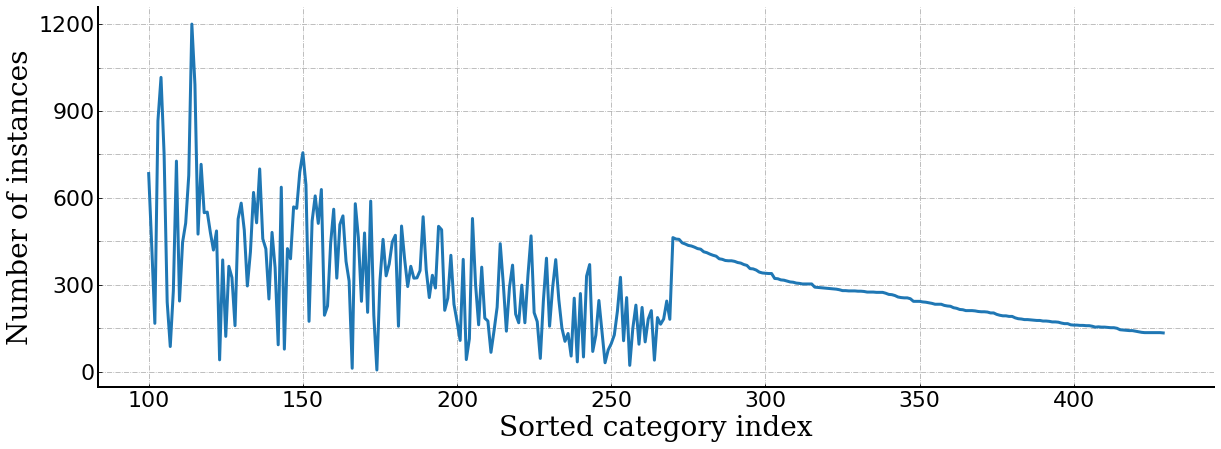

In [37]:
import matplotlib
%matplotlib inline
import pylab
import matplotlib.pyplot as plt
from matplotlib.ticker import  MultipleLocator
# matplotlib.use('Agg')

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
pylab.rcParams['figure.figsize'] = (20.0, 7.0)

x=range(len(id_step1))[100:]
y=ann_num[100:]

fig = plt.figure()
ax = fig.gca()

ymajorLocator = MultipleLocator(300)     
yminorLocator = MultipleLocator(150)       
ax.yaxis.set_major_locator(ymajorLocator)       
ax.yaxis.set_minor_locator(yminorLocator)

plt.plot(x,y, linewidth=3.0)

# plt.yscale('log') #choose log or not
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# 设置坐标标签字体大小

font1 = {'family':'serif','weight': 'normal','size': 28}
ax.set_xlabel('Sorted category index', font1)
ax.set_ylabel('Number of instances', font1)
# plt.legend(frameon=False)

plt.grid(linestyle='-.',which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细

In [38]:
all_tail_images_step1 = []
all_tail_classes_step1 = []
for tail_id, tail_image_step1 in enumerate(tail_images_step1):
    all_tail_images_step1.extend(tail_image_step1)
    all_tail_classes_step1.extend([nBase + nStep*(Step-1)+tail_id+1]*len(tail_image_step1))

In [39]:
ids = []
ids_len = []
ann_num_all_dataset = [0] *len(id_step1)

for index, class_i in enumerate(id_step1):
    ids_i = []
    for img_id in coco_train.ids:
        ann_ids = coco_train.coco.getAnnIds(imgIds=img_id, catIds = class_i,iscrowd=None)    
        anno = coco_train.coco.loadAnns(ann_ids)
        ann_num_all_dataset[index] += len(anno)
        if has_valid_annotation(anno):
            ids_i.append(img_id)
    ids.append(ids_i)
    ids_len.append(len(ids_i))

In [40]:
avg_num_per_img = np.array(ann_num_all_dataset)/np.array(ids_len)
avg_sample_num = np.round(np.mean(ann_num_all_dataset[-nStep:])/avg_num_per_img)[:nBase+nStep*(Step-1)]


In [41]:
len(np.unique(np.array(all_tail_images_step1)))

12852

In [42]:
print(len(all_tail_images_step1))

16349


In [43]:
len(all_tail_images_step1)+int(sum(avg_sample_num))

41499

In [99]:
nIter = 80000
total_iteration = nIter*nGpu
epochs = int(np.floor(total_iteration/(len(all_tail_images_step1)+int(sum(avg_sample_num)))))
iter_img_id = []
iter_cls_id = []
for epoch in range(epochs):
    
    replay_indices_step1 = []
    
    g = torch.Generator()
    g.manual_seed(epoch)
    
    
    replay_images_step1=[]
    replay_images_imgid_step1=[]
    
    for i in range(nBase+nStep*(Step-1)):
        train_images_i_id = [coco_step1.img_map_to_id[idx] for idx in train_images_per_c_step1[i]]
        if int(avg_sample_num[i]) == 0:
            avg_sample_num[i] = 1
#         index_i = torch.randperm(len(train_images_i_id), generator=g).tolist()[:int(avg_sample_num[i])]
        index_i = torch.randint(0, len(train_images_i_id), (int(avg_sample_num[i]),1), generator=g).squeeze(1).tolist()
        img_id_replay_i = np.array(train_images_i_id)[index_i] 
        train_images_i = np.array(train_images_per_c_step1[i])[index_i]
        
        replay_indices_step1.extend([i+1]*int(avg_sample_num[i]))
        replay_images_step1.extend(img_id_replay_i.tolist())   
        replay_images_imgid_step1.append(train_images_i.tolist())
#         print(replay_indices_step1)
    
    
    all_balance_images_step1 = all_tail_images_step1 + replay_images_step1
    all_balance_classes_step1 = all_tail_classes_step1 + replay_indices_step1
#     print(len(all_balance_images_step1))
#     print(len(all_balance_classes_step1))
    
    index_i = torch.randperm(len(all_balance_images_step1), generator=g).tolist()
    img_id_i = [all_balance_images_step1[index] for index in index_i]
    cls_id_i = [all_balance_classes_step1[index] for index in index_i]
    iter_img_id.extend(img_id_i)
    iter_cls_id.extend(cls_id_i)
#     print(len(iter_cls_id))
#     print(len(iter_img_id))
# print(len(iter_cls_id))
# print(len(iter_img_id))
iter_img_id += all_balance_images_step1[: (total_iteration - len(iter_img_id))]
iter_cls_id += all_balance_classes_step1[: (total_iteration - len(iter_cls_id))]

iter_img_id_reshape = np.array(iter_img_id).reshape((nGpu, nIter))
iter_cls_id_reshape = np.array(iter_cls_id).reshape((nGpu, nIter))
iter_img_id_balanced_qry = iter_img_id_reshape.tolist()
iter_cls_id_balanced_qry = iter_cls_id_reshape.tolist()

# json.dump(iter_img_id_balanced_qry, open(os.path.join(save_path, 'lvis_indices_qry_step1_rand_balanced.json'), 'w'))
# json.dump(iter_cls_id_balanced_qry, open(os.path.join(save_path, 'lvis_classes_qry_step1_rand_balanced.json'), 'w'))



In [73]:
len(np.unique(iter_img_id_balanced_qry[0]))

32920

In [45]:
# bin_list = list(np.arange(nAccum))*nIter

# bin_list = [0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7]*nIter
bin_list = [0,0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13,14,14,15,15,16,16,17,17,18,18,19,19]*int(nIter/10)

tail_idx_step1 = list(range(nBase+1+nStep*(Step-1),nBase+1+nStep*Step))
tail_images_step1 = []
for idx_c in tail_idx_step1:    
    tail_images_step1.append([coco_step1.img_map_to_id[idx] for idx in train_images_per_c_step1[idx_c-1]])

# # get_img_info(all_tail_classes, img_ids, classes_per_bin)
data_info_sup  = get_img_info(tail_idx_step1, tail_images_step1, 8)

get_iteration_info(coco_step1, data_info_sup, bin_list, False) 
indices_all, classes_all = get_iteration_batchs(data_info_sup, bin_list)  #indices可以替换dataloader的indices classes存成json告诉网络当前train的是什么class

In [102]:
indices_sup_balanced = []
classes_sup_balanced = []
for indice, classes in zip(indices_all, classes_all):
    classes_sup_balanced.append(classes[0::2])
    indices_sup_balanced.append(indice[0::2])

json.dump(indices_sup_balanced, open(os.path.join(save_path, 'lvis_indices_sup_step1_balanced.json'), 'w'))
json.dump(classes_sup_balanced, open(os.path.join(save_path, 'lvis_indices_sup_cls_step1_balanced.json'), 'w'))

len_epoch = len(all_tail_images_step1)+int(sum(avg_sample_num))
ann_num_balanced = [0]*(nBase + nStep*Step)
for idx, img in zip(iter_cls_id[len_epoch*0:len_epoch*1], iter_img_id[len_epoch*0:len_epoch*1]):
    class_i = id_step1[idx-1]
    ann_ids = coco_step1.coco.getAnnIds(imgIds=coco_step1.id_to_img_map[img], catIds = class_i,iscrowd=None)    
    anno = coco_step1.coco.loadAnns(ann_ids)
    ann_num_balanced[idx-1] += len(anno)

In [48]:
len(indices_sup_balanced[0])

160000

In [49]:
len_epoch

41499

In [50]:
iter_cls_id_balanced_qry[0]

80000

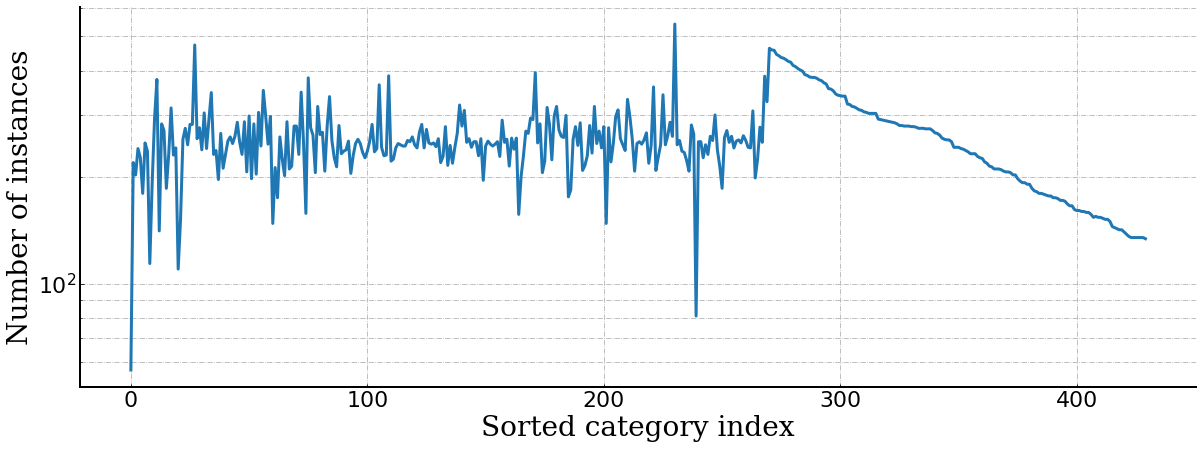

In [101]:
import matplotlib
%matplotlib inline
import pylab
import matplotlib.pyplot as plt
from matplotlib.ticker import  MultipleLocator
# matplotlib.use('Agg')

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
pylab.rcParams['figure.figsize'] = (20.0, 7.0)

# x1=range(nBase+(Step-1)*nStep,nBase+Step*nStep)
x1=range(nBase+Step*nStep)
y1=ann_num_balanced
# y1=ann_num[-nStep:]

# x2=range(nBase+(Step-1)*nStep)
# y2=ann_num_replay

fig = plt.figure()
ax = fig.gca()

ymajorLocator = MultipleLocator(200)     
yminorLocator = MultipleLocator(100)       
ax.yaxis.set_major_locator(ymajorLocator)       
ax.yaxis.set_minor_locator(yminorLocator)
# ax.set_ylim([0,2000])
plt.plot(x1,y1, linewidth=3.0)
# plt.plot(x2,y2, linewidth=3.0)


plt.yscale('log') #choose log or not
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# 设置坐标标签字体大小

font1 = {'family':'serif','weight': 'normal','size': 28}
ax.set_xlabel('Sorted category index', font1)
ax.set_ylabel('Number of instances', font1)
# plt.legend(frameon=False)

plt.grid(linestyle='-.',which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细

In [47]:
a= torch.tensor([])

## rand but not new

In [104]:
nIter = 80000
total_iteration = nIter*nGpu
epochs = int(np.floor(total_iteration/(len(all_tail_images_step1)+int(sum(avg_sample_num)))))
iter_img_id = []
iter_cls_id = []
for epoch in range(epochs):
    
    replay_indices_step1 = []
    
    g = torch.Generator()
#     g.manual_seed(epoch)
    g.manual_seed(0)
    
    replay_images_step1=[]
    replay_images_imgid_step1=[]
    
    for i in range(nBase+nStep*(Step-1)):
        train_images_i_id = [coco_step1.img_map_to_id[idx] for idx in train_images_per_c_step1[i]]
        if int(avg_sample_num[i]) == 0:
            avg_sample_num[i] = 1
#         index_i = torch.randperm(len(train_images_i_id), generator=g).tolist()[:int(avg_sample_num[i])]
        index_i = torch.randint(0, len(train_images_i_id), (int(avg_sample_num[i]),1), generator=g).squeeze(1).tolist()
        img_id_replay_i = np.array(train_images_i_id)[index_i] 
        train_images_i = np.array(train_images_per_c_step1[i])[index_i]
        
        replay_indices_step1.extend([i+1]*int(avg_sample_num[i]))
        replay_images_step1.extend(img_id_replay_i.tolist())   
        replay_images_imgid_step1.append(train_images_i.tolist())
#         print(replay_indices_step1)
    
    
    all_balance_images_step1 = all_tail_images_step1 + replay_images_step1
    all_balance_classes_step1 = all_tail_classes_step1 + replay_indices_step1
#     print(len(all_balance_images_step1))
#     print(len(all_balance_classes_step1))
    
    index_i = torch.randperm(len(all_balance_images_step1), generator=g).tolist()
    img_id_i = [all_balance_images_step1[index] for index in index_i]
    cls_id_i = [all_balance_classes_step1[index] for index in index_i]
    iter_img_id.extend(img_id_i)
    iter_cls_id.extend(cls_id_i)
#     print(len(iter_cls_id))
#     print(len(iter_img_id))
# print(len(iter_cls_id))
# print(len(iter_img_id))
iter_img_id += all_balance_images_step1[: (total_iteration - len(iter_img_id))]
iter_cls_id += all_balance_classes_step1[: (total_iteration - len(iter_cls_id))]

iter_img_id_reshape = np.array(iter_img_id).reshape((nGpu, nIter))
iter_cls_id_reshape = np.array(iter_cls_id).reshape((nGpu, nIter))
iter_img_id_balanced_qry = iter_img_id_reshape.tolist()
iter_cls_id_balanced_qry = iter_cls_id_reshape.tolist()

json.dump(iter_img_id_balanced_qry, open(os.path.join(save_path, 'lvis_indices_qry_step1_rand_balanced_wo_resample.json'), 'w'))
json.dump(iter_cls_id_balanced_qry, open(os.path.join(save_path, 'lvis_classes_qry_step1_rand_balanced_wo_resample.json'), 'w'))



In [94]:

len_epoch = len(all_tail_images_step1)+int(sum(avg_sample_num))
ann_num_balanced = [0]*(nBase + nStep*Step)
for idx, img in zip(iter_cls_id[len_epoch*1:len_epoch*2], iter_img_id[len_epoch*1:len_epoch*2]):
    class_i = id_step1[idx-1]
    ann_ids = coco_step1.coco.getAnnIds(imgIds=coco_step1.id_to_img_map[img], catIds = class_i,iscrowd=None)    
    anno = coco_step1.coco.loadAnns(ann_ids)
    ann_num_balanced[idx-1] += len(anno)

In [95]:
len(indices_sup_balanced[0])

160000

In [96]:
len_epoch

41499

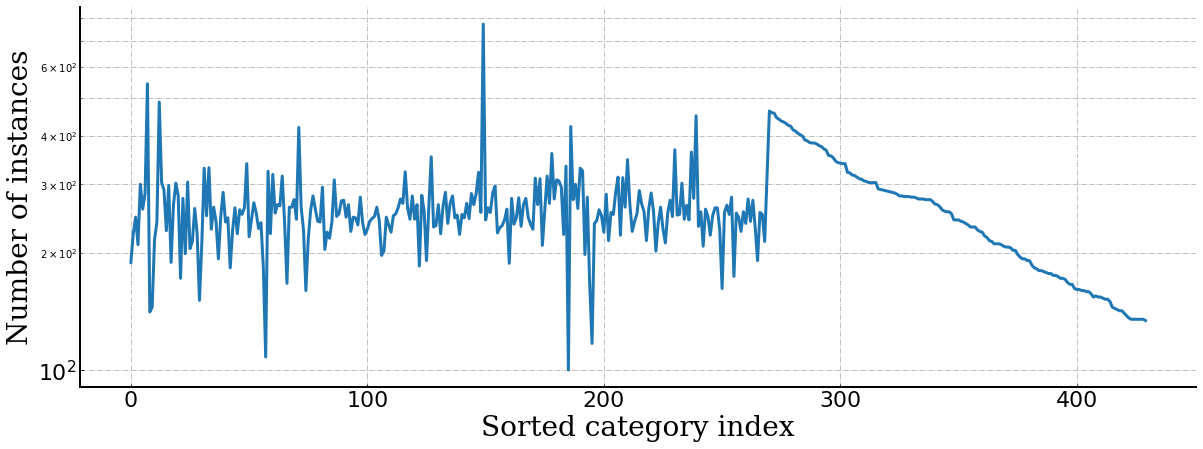

In [93]:
import matplotlib
%matplotlib inline
import pylab
import matplotlib.pyplot as plt
from matplotlib.ticker import  MultipleLocator
# matplotlib.use('Agg')

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
pylab.rcParams['figure.figsize'] = (20.0, 7.0)

# x1=range(nBase+(Step-1)*nStep,nBase+Step*nStep)
x1=range(nBase+Step*nStep)
y1=ann_num_balanced
# y1=ann_num[-nStep:]

# x2=range(nBase+(Step-1)*nStep)
# y2=ann_num_replay

fig = plt.figure()
ax = fig.gca()

ymajorLocator = MultipleLocator(200)     
yminorLocator = MultipleLocator(100)       
ax.yaxis.set_major_locator(ymajorLocator)       
ax.yaxis.set_minor_locator(yminorLocator)
# ax.set_ylim([0,2000])
plt.plot(x1,y1, linewidth=3.0)
# plt.plot(x2,y2, linewidth=3.0)


plt.yscale('log') #choose log or not
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# 设置坐标标签字体大小

font1 = {'family':'serif','weight': 'normal','size': 28}
ax.set_xlabel('Sorted category index', font1)
ax.set_ylabel('Number of instances', font1)
# plt.legend(frameon=False)

plt.grid(linestyle='-.',which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细

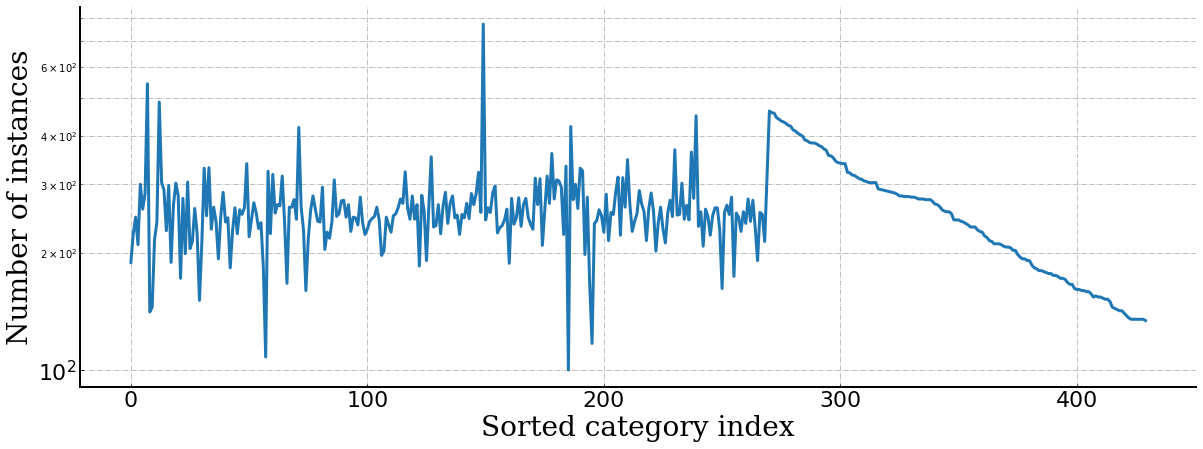

In [98]:
import matplotlib
%matplotlib inline
import pylab
import matplotlib.pyplot as plt
from matplotlib.ticker import  MultipleLocator
# matplotlib.use('Agg')

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
pylab.rcParams['figure.figsize'] = (20.0, 7.0)

# x1=range(nBase+(Step-1)*nStep,nBase+Step*nStep)
x1=range(nBase+Step*nStep)
y1=ann_num_balanced
# y1=ann_num[-nStep:]

# x2=range(nBase+(Step-1)*nStep)
# y2=ann_num_replay

fig = plt.figure()
ax = fig.gca()

ymajorLocator = MultipleLocator(200)     
yminorLocator = MultipleLocator(100)       
ax.yaxis.set_major_locator(ymajorLocator)       
ax.yaxis.set_minor_locator(yminorLocator)
# ax.set_ylim([0,2000])
plt.plot(x1,y1, linewidth=3.0)
# plt.plot(x2,y2, linewidth=3.0)


plt.yscale('log') #choose log or not
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# 设置坐标标签字体大小

font1 = {'family':'serif','weight': 'normal','size': 28}
ax.set_xlabel('Sorted category index', font1)
ax.set_ylabel('Number of instances', font1)
# plt.legend(frameon=False)

plt.grid(linestyle='-.',which='both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细